# Example of the stationary bootstrap algorithm in practice

In [234]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

## Goal

The goal of this workbook is to demonstrate the use of the stationary bootstrap algorithm. In this example, 3 new samples are generated.

In [149]:
nSample = 3 # Number of generated samples

EURO denominated 6M interest-rate-swap rate obtained from https://www.teleborsa.it/Quotazioni/Tassi/Eurirs for date 12/11/2021 and interpolated using the Smith & Wilson algorithm for missing durations.

In [196]:
swap = pd.DataFrame({'Swap rate': [-0.00497999999999998,
-0.00336999999999998,
-0.00219000000000003,
-0.00137999999999994,
-0.000839999999999952,
-0.000349999999999961,
0.000140000000000029,
0.000669999999999948,
0.00116999999999989,
0.00165999999999999,
0.00208999999999993,
0.00245999999999991,
0.00277690952371801,
0.00303541131903184,
0.00323000000000007,
0.00336225372994803,
0.00345212702349018,
0.00351682745133952,
0.00356726077755898,
0.00360999999999989,
0.00364393467821089,
0.00365001038370538,
0.00360991273768496,
0.00350996855727703,
0.00333999999999990,
0.00310968998405592,
0.00288888447388769,
0.00274107227669318,
0.00271077735186531,
0.00283000000000011]})

In [197]:
swap.head()

,Swap rate
0,-0.00498
1,-0.00337
2,-0.00219
3,-0.00138
4,-0.00084


In [198]:
sampleLen = swap.size; # Length of the sample will be the same as the input. 

The swap rates cann ot be stacked in a sampling algorithm therefore, they are used to   Vector with the 1-year forward curve. Convert rates into 1-year forward curve

Note that you loose 1 degree of freedom when converting from rates to 1-year-forward rates using the formula

$ fwd(t) = \frac{(1 + r_{SWAP}(0, t+1))^{t+1}}{(1 + r_{SWAP}(0, t))^{t}}$

In [199]:
forwards = np.zeros((sampleLen-1,1)) 

In [200]:
for iTime in range(0,sampleLen-1): 
    forwards[iTime][0] = np.power(1 + swap["Swap rate"][iTime+1],iTime+1) / np.power(1+swap["Swap rate"][iTime], iTime) - 1

In [201]:
forwards = pd.DataFrame(forwards, columns={'Forward rate'})

In [202]:
forwards.head()

,Forward rate
0,-0.003370
1,-0.001009
2,0.000242
3,0.000782
4,0.001612


Calculated using the method presented in 2004 paper by Politis & White.

In [203]:
m = 3.8299

Generate Stationary bootstraped samples

In [185]:
def StationaryBootstrap(data: np.ndarray, m, sampleLength)-> np.ndarray:
    """
    Returns a bootstraped sample of the time-series "data" of length "sampleLength. 
    The algorithm used is stationary bootstrap from 1994 Politis & Romano.
    
    Args:     
        data ... ndarray array. A single vector of numbers containing the time-series.
        m    ... floating number. Parameter to stationary bootstrap indicating the average length of each block in the sample.
        sampleLength ... integer. Length of the bootstrapped sample returned as output.
     
    Returns:     
        sample ... ndarray array containing the final bootstraped sample.
      
    Example of use:
    >>> import numpy as np
    >>> data = np.array([1,2,3,4,5,6,7,8,9,10])
    >>> m = 4
    >>> sampleLength = 12
    >>> StationaryBootstrap(data, m, sampleLength)
    Out[0]:  array([[9.],
                    [3.],
                    [4.],
                    [5.],
                    [6.],
                    [7.],
                    [8.],
                    [7.],
                    [2.],
                    [3.],
                    [4.],
                    [2.]])

    Original paper about stationary bootstrap:
    Dimitris N. Politis & Joseph P. Romano (1994) The Stationary Bootstrap, Journal of the American Statistical 
        Association, 89:428, 1303-1313, DOI: 10.1080/01621459.1994.10476870    

    Implemented by Gregor Fabjan from Qnity Consultants on 12/11/2021.

    """
    accept = 1/m  
    lenData = data.shape[0]

    sampleIndex = np.random.randint(0,high =lenData,size=1);
    sample = np.zeros((sampleLength,1))
    for iSample in range(sampleLength):
        if np.random.uniform(0,1,1)>=accept:
            sampleIndex += 1
            if sampleIndex >= lenData:
                sampleIndex=0        
        else:
            sampleIndex = np.random.randint(0,high = lenData,size=1)

        sample[iSample,0] = data[sampleIndex]
    return sample

In this step, the samples are generated by repeatedly calling th StationaryBootstrap function. These samples are then saved into the Samples array

In [230]:
for iSample in range(0, nSample):
    if iSample == 0:
        Samples = np.array(StationaryBootstrap(forwards.values,m,sampleLen))
    else:
        Samples = np.append(Samples, np.array(StationaryBootstrap(forwards.values,m,sampleLen)),axis=1)

In [232]:
Samples = pd.DataFrame(Samples)
Samples.head()

,0,1,2
0,-0.002402,0.004801,0.006168
1,-0.002615,0.004553,0.002768
2,-0.001094,0.004425,0.001314
3,0.001893,0.004380,0.005968
4,0.006174,0.003772,0.006168


<IPython.core.display.Javascript object>


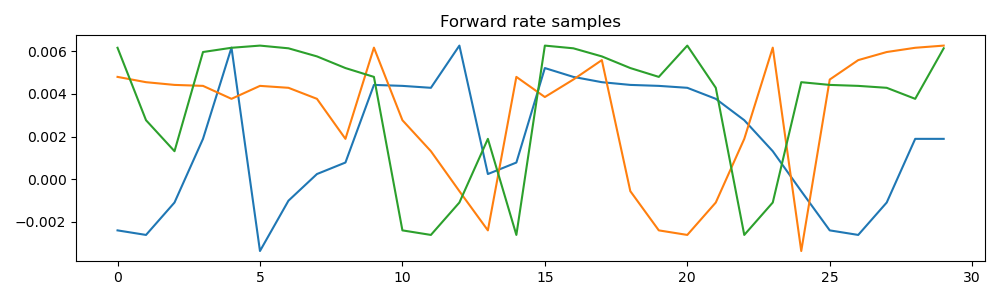

In [242]:
plot_data = Samples.copy().to_numpy()
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(plot_data) 
ax.set_title('Forward rate samples')
fig.tight_layout()